# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

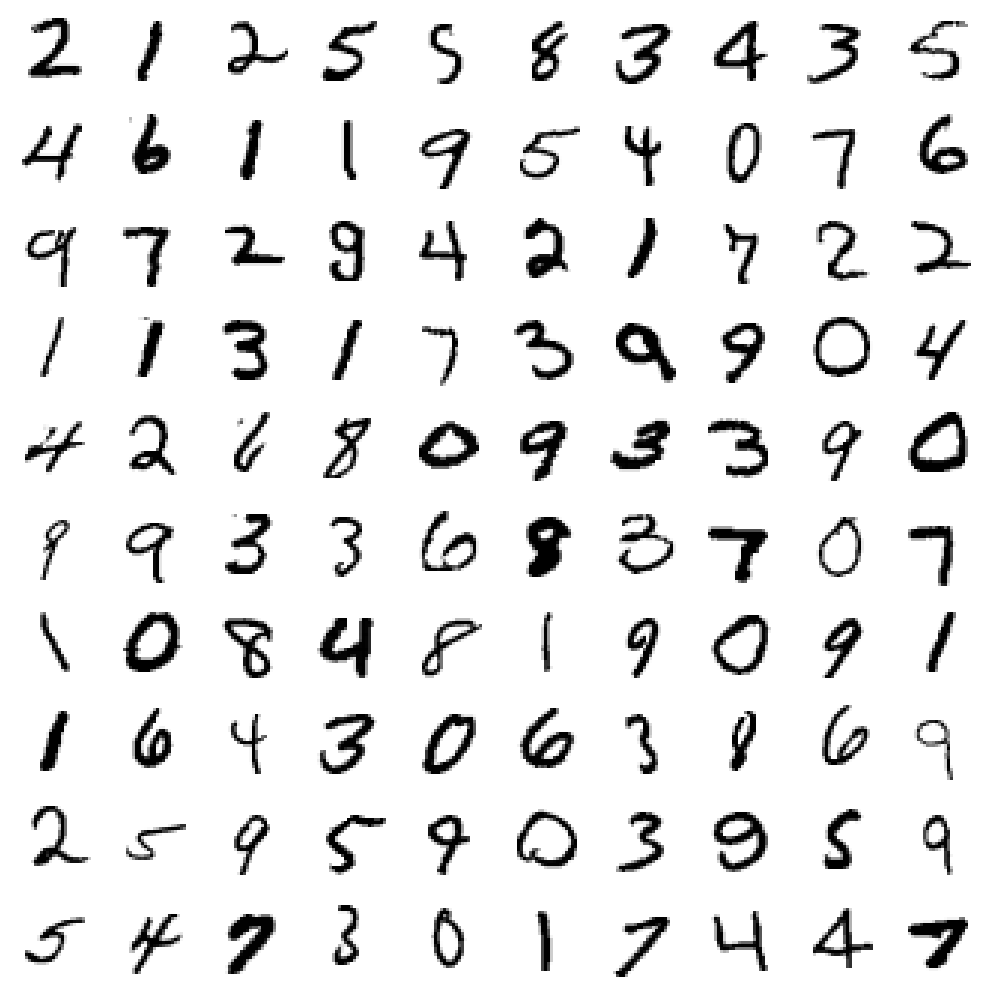

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

Compile and train the network (note that this could take a while).

In [3]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 74s 156ms/step - loss: 0.2401 - accuracy: 0.9269 - val_loss: 0.0555 - val_accuracy: 0.9835
Epoch 2/12
469/469 [==============================] - 72s 153ms/step - loss: 0.0837 - accuracy: 0.9754 - val_loss: 0.0372 - val_accuracy: 0.9867
Epoch 3/12
469/469 [==============================] - 74s 157ms/step - loss: 0.0623 - accuracy: 0.9811 - val_loss: 0.0293 - val_accuracy: 0.9906
Epoch 4/12
469/469 [==============================] - 73s 156ms/step - loss: 0.0522 - accuracy: 0.9843 - val_loss: 0.0332 - val_accuracy: 0.9884
Epoch 5/12
469/469 [==============================] - 73s 156ms/step - loss: 0.0421 - accuracy: 0.9872 - val_loss: 0.0321 - val_accuracy: 0.9895
Epoch 6/12
469/469 [==============================] - 86s 183ms/step - loss: 0.0387 - accuracy: 0.9877 - val_loss: 0.0340 - val_accuracy: 0.9901
Epoch 7/12
469/469 [==============================] - 87s 185ms/step - loss: 0.0330 - accuracy: 0.9892 - val_loss: 0.0272 - val_ac

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [4]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.026615850627422333
Test accuracy: 0.9925000071525574


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. The images corresponding to the DRIVE test set can be found [here](https://www.dropbox.com/s/zk51wgupimw7jd9/DRIVE.zip?dl=0).

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


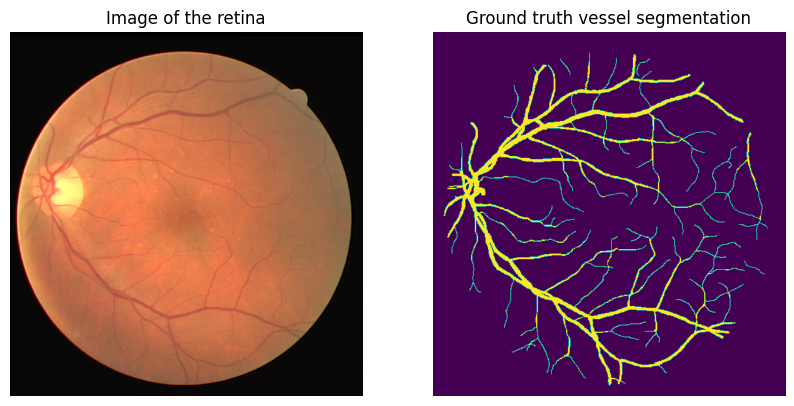

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

import os
home = os.getcwd()
os.chdir(r"C:\Users\BramUser\Desktop\Studie + Tilburg\DSAI\Machine Learning for Medical Imaging and Biology\repository\8dm50-machine-learning\practicals\code")
from unet_utils import load_data, extract_patches, preprocessing, datagenerator
from unet_model import unet
os.chdir(home)

# location of the DRIVE dataset
data_folder = r'C:\Users\BramUser\Desktop\Studie + Tilburg\DSAI\Machine Learning for Medical Imaging and Biology\DRIVE'
train_paths = glob(data_folder + r'/training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


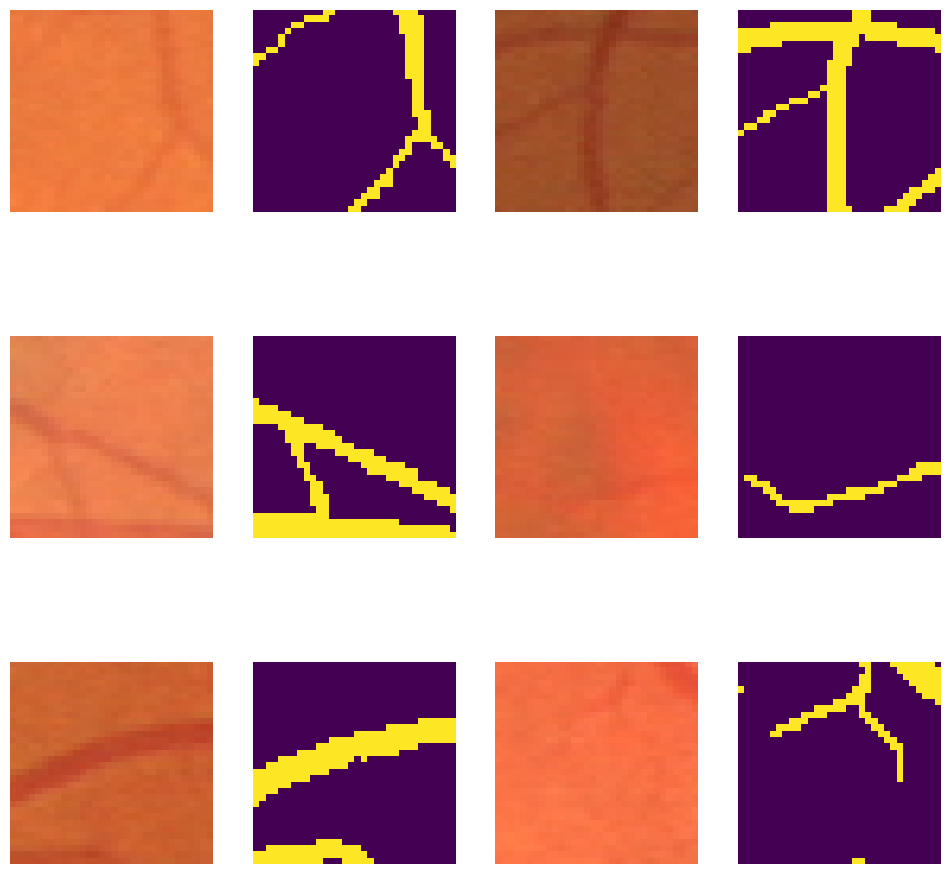

In [6]:
# from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [7]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [8]:
import os
# from unet_model import unet
# from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/250


C:\Users\BramUser\AppData\Local\Temp\ipykernel_4816\3483829526.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),


50/50 - 65s - loss: 0.5003 - accuracy: 0.8320 - val_loss: 0.7416 - val_accuracy: 0.4800 - 65s/epoch - 1s/step
Epoch 2/250
50/50 - 58s - loss: 0.2991 - accuracy: 0.9511 - val_loss: 0.5062 - val_accuracy: 0.9211 - 58s/epoch - 1s/step
Epoch 3/250
50/50 - 61s - loss: 0.2466 - accuracy: 0.9511 - val_loss: 0.9630 - val_accuracy: 0.2818 - 61s/epoch - 1s/step
Epoch 4/250
50/50 - 58s - loss: 0.1832 - accuracy: 0.9553 - val_loss: 6.4317 - val_accuracy: 0.1442 - 58s/epoch - 1s/step
Epoch 5/250
50/50 - 55s - loss: 0.1635 - accuracy: 0.9563 - val_loss: 0.5208 - val_accuracy: 0.9212 - 55s/epoch - 1s/step
Epoch 6/250
50/50 - 50s - loss: 0.1383 - accuracy: 0.9595 - val_loss: 0.4355 - val_accuracy: 0.9212 - 50s/epoch - 1s/step
Epoch 7/250
50/50 - 51s - loss: 0.1409 - accuracy: 0.9572 - val_loss: 0.3050 - val_accuracy: 0.9230 - 51s/epoch - 1s/step
Epoch 8/250
50/50 - 50s - loss: 0.1413 - accuracy: 0.9556 - val_loss: 6.4844 - val_accuracy: 0.3187 - 50s/epoch - 1s/step
Epoch 9/250
50/50 - 52s - loss: 0.11

### Visualizing the segmentation results

1/1 [==============================] - 2s 2s/step


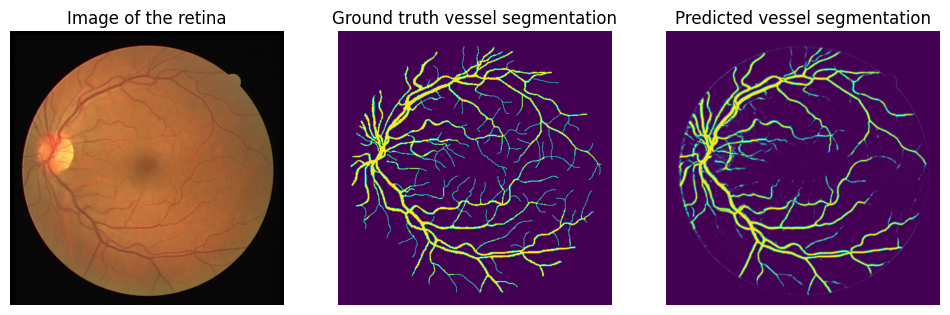

In [9]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + '/test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

Answer:
- These parameters correspond to all the weights between the input layer and the first hidden layer. In the first convolutional layer, we have a filter of size 3x3 and 1 channel (i.e., the last dimension of the input shape). Moreover, there are 32 filters in total (the first parameter of the `Conv2D` layer). Hence, the total number of parameters is (3 x 3 + 1) x 32 = 320. We add 1 because in every filter there is a bias term. In general, the number of parameters in a convolutional layer corresponds to:
\begin{align}
    \text{Total Parameters} = \left(K_h \times K_w \times C + 1\right) \times F
\end{align}
, where 
  - $K_h$: The height of the convolutional filter.
  - $K_w$: The width of the convolutional filter.
  - $C$: The number of input channels (e.g., 1 for grayscale images, 3 for RGB images).
  - $F$: The number of filters (also called the number of output channels).
  - Bias term: Each filter has one bias term.

- The parameters in the first fully connected layer amount to 1,1779,776 parameters because of the following reason: in the previous layer (the `Flatten` layer), there are 9,216 parameters (these correspond to the weights and biases of the previous layer; however, 25% of the parameters have been dropped because of the `Dropout` layer). Since there are 128 filters, we get 128 x 9,216 = 1,179,648. Adding 128 to this because there is 1 bias term per filter we get a total of 1,179,776. The general expression to compute the total amount of parameters in a fully connected layer is:
\begin{align}
    \text{Total Parameters} = \left(N_{\text{input}} \times N_{\text{output}}\right) + N_{\text{output}}
\end{align}
, where
  - $N_{\text{input}}$: The number of input neurons from the previous layer.
  - $N_{\text{output}}$: The number of output neurons in the current layer.
  - Bias term: Each output neuron has one bias term.

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 




In [10]:
def original_mnist_model():
    # Original MNIST model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())  # Flatten layer
    model.add(Dense(128, activation='relu'))  # Fully-connected layer
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))  # Fully-connected output layer

    return model

# Initialize original model
original_model = original_mnist_model()
original_model.summary()

from keras.layers import GlobalAveragePooling2D

def conv_mnist_model():
    # Fully-Convolutional MNIST Model
    model_fc = Sequential()

    # Same convolutional layers as before
    model_fc.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model_fc.add(Conv2D(64, (3, 3), activation='relu'))
    model_fc.add(MaxPooling2D(pool_size=(2, 2)))
    model_fc.add(Dropout(0.25))

    # Replace Flatten + Dense(128) with Conv2D
    # Keep 12x12x64 output shape from the previous MaxPooling layer
    model_fc.add(Conv2D(128, (12, 12), activation='relu'))  # This is equivalent to Dense(128)
    model_fc.add(Dropout(0.5))

    # Replace Dense(10) with a 1x1 convolution followed by GlobalAveragePooling
    model_fc.add(Conv2D(10, (1, 1), activation='softmax'))  # This replaces Dense(10)
    model_fc.add(GlobalAveragePooling2D())  # Global Average Pooling replaces the Flatten step

    return model_fc

# Initialize fully convolutional model
conv_model = conv_mnist_model()
conv_model.summary()

# load the MNIST the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
X_train = (X_train / 255.0).astype(np.float32)
X_test = (X_test / 255.0).astype(np.float32)

# convert the data to channel-last
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1179776   
                                                      

In [11]:
# Fit the models
original_model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
conv_model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

# Fit both models for 3 epochs
history_original = original_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
history_conv = conv_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 86s 181ms/step - loss: 0.2313 - accuracy: 0.9296 - val_loss: 0.0593 - val_accuracy: 0.9812
Epoch 2/10
469/469 [==============================] - 82s 174ms/step - loss: 0.0855 - accuracy: 0.9739 - val_loss: 0.0414 - val_accuracy: 0.9862
Epoch 3/10
469/469 [==============================] - 82s 174ms/step - loss: 0.0609 - accuracy: 0.9820 - val_loss: 0.0328 - val_accuracy: 0.9882
Epoch 4/10
469/469 [==============================] - 84s 178ms/step - loss: 0.0507 - accuracy: 0.9848 - val_loss: 0.0327 - val_accuracy: 0.9892
Epoch 5/10
469/469 [==============================] - 83s 178ms/step - loss: 0.0424 - accuracy: 0.9870 - val_loss: 0.0298 - val_accuracy: 0.9897
Epoch 6/10
469/469 [==============================] - 82s 176ms/step - loss: 0.0376 - accuracy: 0.9880 - val_loss: 0.0279 - val_accuracy: 0.9910
Epoch 7/10
469/469 [==============================] - 83s 178ms/step - loss: 0.0330 - accuracy: 0.9893 - val_loss: 0.0268 - val_ac

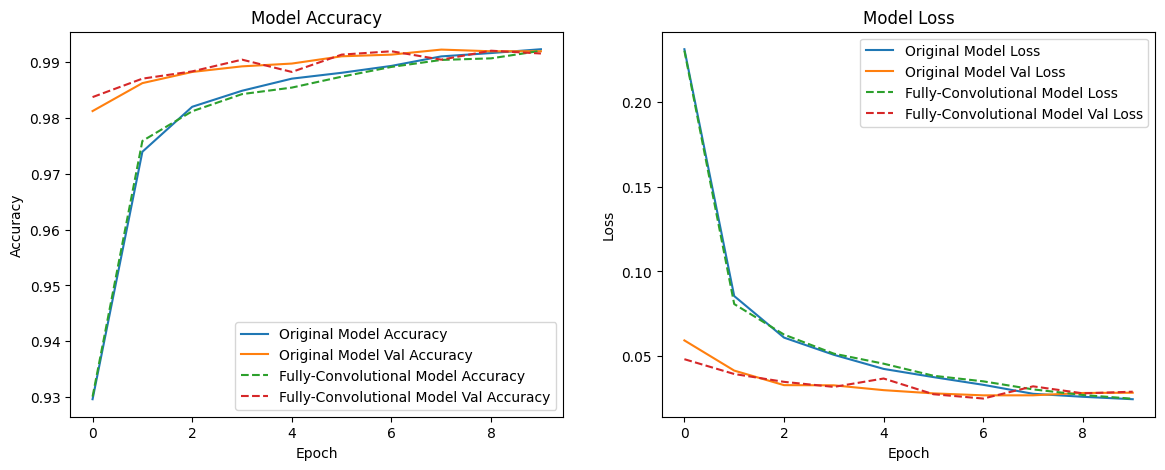

In [12]:
# Plot accuracy and loss
def plot_accuracy_and_loss(history1, history2):
    # Plot accuracy
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Original Model Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Original Model Val Accuracy')
    plt.plot(history2.history['accuracy'], label='Fully-Convolutional Model Accuracy', linestyle='--')
    plt.plot(history2.history['val_accuracy'], label='Fully-Convolutional Model Val Accuracy', linestyle='--')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Original Model Loss')
    plt.plot(history1.history['val_loss'], label='Original Model Val Loss')
    plt.plot(history2.history['loss'], label='Fully-Convolutional Model Loss', linestyle='--')
    plt.plot(history2.history['val_loss'], label='Fully-Convolutional Model Val Loss', linestyle='--')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    plt.show()

plot_accuracy_and_loss(history_original, history_conv)

Add text

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

Answer:
The skip connections ensure that the information from the encoder and decoder are concatenated at the same level. It will be possible an exact same architecture without the skip connections. However, this will result in a loss of information, as the decoder will only use the information at the bottleneck (i.e., a lower amount of trained features). Hence, not much local information from the encoder will be used in the decoder phase when the skip connections are omitted. This results in lower accuracy and worse predicted segmentations

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

Data augmentation results in less overfitting because it results in more varied data being seen and applied during training phase. Not only does it increase the number of available data, it also results in more visually different images (i.e., an image that has been randomly flipped, rotated, etc.). This makes the model more robust to different appearing images and hence results in less overfitting. However, data augmentation cannot be applied to the test samples, since the purpose of the test samples is to see to what effect the model performance can be generalized to unseen data.

Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

